# K-Means Clustering in Sports Analytics 

## Introduction

This tutorial will teach you how to perform K-Means clustering analysis in the field of Sports Analytics!


### What is Clustering?

Clustering is a form of **Unsupervised Learning**, a machine learning algorithm technique machine that works to label and classify raw data. This is in contrast to Supervised Learning algorithms, which most likely uses "cleaner" data with labels, classifications, and categories.

An example of **Supervised Learning** would be the following:

* Predicting a student's numeric grade on a midterm exam with variables of each student's hours of sleep, GPA, and hours of preparation.

An example of **Unsupervised Learning** would be the following:

* Finding a subgroup of an artist's songs based on their regional popularity.

In this tutorial, we will be diving into the applications of a certain clustering algorithm, **K-Means Clustering**.

### What is K-Means Clustering?

K-Means clustering is a clustering algorithm that serves to **branch a dataset of n observations into k clusters**, where each observation is **placed into the cluster with the nearest mean in respect to d dimensions**.

First, you choose an arbitrary k amount of observations from the dataset as centroids.

Then, you iterate through all the observations in the dataset, assigning each observation to a cluster and reassigning centroid points as necessary to minimize variances between datapoints in a cluster.

Your final result of applying the algorithm should be a dataset split into k clusters where the sum of the distance between observations in a centroid is minimized.


### Clustering in Sports Analytics

The digital age has brought upon a stunning change in professional sports organizations; teams are relying more and more on data driven decisions and research scientists to help make winning plays on the field. 

Thus, as databases and the overall datasets in the world of sports are rather new and "raw", the methods of Unsupervised Learning come into play. Clustering and other methods of Unsupervised Learning are optimized in situations and datasets with much to be learned, leaving sports analytics an ideal playground for these methods.

In this tutorial, we will explore clustering similiar types of NBA players and teams!

## Datasets and Libraries

We will acquire our dataset for the tutorial from an NBA API package, which accesses game, player, and team data from NBA.com. We install the package with the following command.

In [ ]:
import sys
!{sys.executable} -m pip install nba-api

We extract the API data for players and teams with the following commands.

In [ ]:
from nba_api.stats.endpoints import commonplayerinfo as commonInfo
from nba_api.stats.endpoints import leaguedashplayerstats as playerStats
from nba_api.stats.static import teams

For this tutorial, we will use the following libraries to conduct our clustering analysis.

In [416]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import math
import requests
%matplotlib inline
import matplotlib.pyplot as plt

## Clustering with NBA Data

### Extracting NBA Player Data

For the first clustering analysis, I want to try grouping similiar types of NBA players together! In order to continue with this, I want to get a dataframe with all the NBA players in a season with their respective stats. In the following chunk, I request all the data for every player in the 2018-2019 NBA season and convert it to a dataframe by calling the method "LeagueDashPlayerStats(season='2018-19')" on the call to our NBA API package.

In [471]:
player_stats = playerStats.LeagueDashPlayerStats(season='2018-19')
df = player_stats.get_data_frames()[0]
df = pd.DataFrame(df)
display(df)

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,...,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS
0,203932,Aaron Gordon,1610612753,ORL,23.0,78,40,38,0.513,2632.533333,...,471,439,39,52,91,43,34,38,5,"203932,1610612753"
1,1628988,Aaron Holiday,1610612754,IND,22.0,50,31,19,0.620,645.830000,...,218,210,283,302,97,324,261,38,5,"1628988,1610612754"
2,1627846,Abdel Nader,1610612760,OKC,25.0,61,38,23,0.623,693.656667,...,172,203,351,324,464,344,261,38,5,"1627846,1610612760"
3,201143,Al Horford,1610612738,BOS,33.0,68,41,27,0.603,1972.683333,...,353,343,154,97,37,64,70,16,5,"201143,1610612738"
4,202329,Al-Farouq Aminu,1610612757,POR,28.0,81,52,29,0.642,2291.698333,...,353,382,128,133,17,95,60,38,5,"202329,1610612757"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,203897,Zach LaVine,1610612741,CHI,24.0,63,16,47,0.254,2170.855000,...,526,372,40,30,512,54,159,38,5,"203897,1610612741"
526,1629155,Zach Lofton,1610612765,DET,26.0,1,1,0,1.000,3.750000,...,1,1,513,521,226,523,261,38,5,"1629155,1610612765"
527,2585,Zaza Pachulia,1610612765,DET,35.0,68,35,33,0.515,878.165000,...,262,400,134,316,424,281,261,38,5,"2585,1610612765"
528,1629015,Zhaire Smith,1610612755,PHI,20.0,6,2,4,0.333,110.616667,...,91,62,464,447,183,456,261,38,5,"1629015,1610612755"


### Filtering the Dataset

Now that we have our raw dataframe, we want to clean the data so we work with relevant players and statistics (rows and columns!).  

In the following chunk, I filter by the following:
* I filter by selecting "box statistics" columns, the most traditionally important game statistics of an NBA player. 

* I filter df["GP"],  the games played column, by requiring that every player in the dataframe has played the statistical minimumal amount of games to qualify for NBA League Leaders. By doing so, I make sure there are no outliers in the data that will skew our analysis.

In [472]:
traditionalDf = df[["PLAYER_ID", "PLAYER_NAME", "GP", "AGE", "FGM", "FGA", "FG3M", "FG_PCT",
         "FG3A", "FG3_PCT", "FTM", "FTA", "FT_PCT", "REB", "AST", "TOV", "STL", "BLK", "PTS",
                   "NBA_FANTASY_PTS", "PLUS_MINUS_RANK"] ]
qualified = traditionalDf[traditionalDf["GP"] >=  58]
qualified = pd.DataFrame(qualified)    

Now that we have our desired dataset, we proceed with preprocessing our data for the K-Means clustering algorithm.

### Preprocessing Data 

In order to proceed with performing K-Means clustering, we want to perform the methods of Standardization and PCA on the data.

Before I standardize, I pick a random handful of statistics from traditionalDf to base our clustering on.

**Standardization**

We first standardize the data by subtracting the sample mean in each column of the data frame from the data values in that column, and then dividing the difference by the sample standard deviation of the column’s data.

This is done by calling StandardScalar() on our desired dataframe.


In [473]:
numeric = qualified[["FG3M",
         "FG3_PCT", "REB", "AST", "BLK", "PTS",
                    "NBA_FANTASY_PTS", "PLUS_MINUS_RANK"] ]
scaler = StandardScaler()
standardized = scaler.fit_transform(numeric)

**PCA (Principical Component Analysis)**

Now that we have our standardized data, we want to perform PCA, Principal Component Analysis, on the data.

PCA is an algorithm in which one takes the standardized data in a data frame, finds their centroid, and rotates the data around that centroid.

PCA is useful for reducing dimensionality, as running the data through PCA creates n principal components for n dimensions whose proportion of variance can be analyzed to reduce dimensions.

In the following chunk, we perform PCA and find the principal components of our player data by fitting it to the dataframe.

In [474]:
pca = PCA()
analyzed = pca.fit(standardized)
componentPCA = pca.fit_transform(standardized)

Next, we aim to find the proportion of variance explained by the principle components to attempt to reduce the dimensionality.

We find the variance proportion for each component by calling the method "explained_variance_ratio_" on the fitted PCA from the previous chunk.

We follow the basic standard for selecting the number of dimensions to retain by choosing the smallest number of PCs that explain > 90% of the variance.

In [475]:
ratios = analyzed.explained_variance_ratio_
x = []
for i in range(len(ratios)):
    x.append(i)
cumsums = []
count = 0
for i in range(len(ratios)):
    count += ratios[i]
    cumsums.append(count)
total = 0
components = 0
for i in range(len(ratios)):
    total += ratios[i]
    if total > .90:
        components = i
        break

We visualize the cumulative proportion of variances using matplotlib.

3


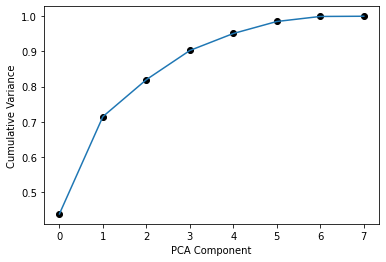

In [477]:
plt.plot(x, cumsums, 'o', color='black')
plt.plot(x, cumsums)
plt.xlabel("PCA Component")
plt.ylabel("Cumulative Variance")
print(components)

We select **three dimensions** according to our standard and visualizations for selecting the number of dimensions.

### K-Means Algorithm

**How Many Clusters Should You Use?**

Now that we fully processed our data for our K-Means algorithm, we do the following:
* After analyzing the PCA variances of our transformed data, we know to use 3 dimensions with our 3 principal components

We now test for the optimal amount of clusters with our data; this is done by attempting to minimize the inertia, which is also known as WCSS (within-cluster sum-of-squares criterion).

We verify this with two tests:

* Inertia (WCSS) Graph Elbow Test: After running the K-Means algorithim on 10 different cluster values, graph the inertia values and find the 'Elbow Point', where the change in inertia between clusters beguns to stabilize and 'flatten'. The point where the Elbow occurs can be interpreted as the most optimal cluster value.


* Silhouette Score Test: A score for how accurate the data is clustered . When the score is at its peak, it can be interpeted as the most optimal cluster value


In [479]:
inertia = []
silScores = []
#tests intertia for different cluster values
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(componentPCA[:, :components])
    inertia += [kmeans.inertia_]
#finds silhouette score for different cluster values
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(componentPCA[:, :components])
    kSilScore = silhouette_score(componentPCA[:, :components], kmeans.labels_, metric = 'euclidean')
    silScores += [kSilScore]
x = []
for i in range(1 ,10):
    x.append(i)
clusterScores = []
for i in range(2,11):
    clusterScores += [i]

#### WCSS Plot

Text(0, 0.5, 'Inertia')

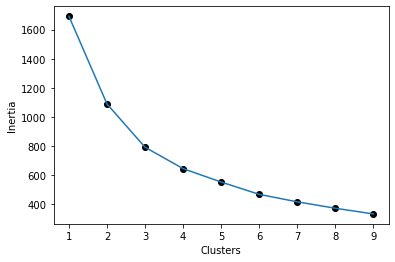

In [480]:
plt.plot(x, inertia, 'o', color='black')
plt.plot(x, inertia)
plt.xlabel("Clusters")
plt.ylabel("Inertia")

#### Silhouette Score Plot

Text(0, 0.5, 'Silhouette Score')

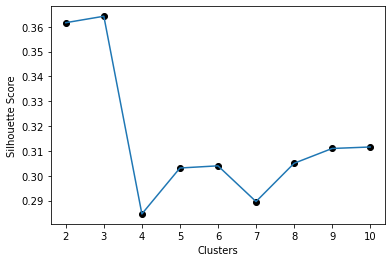

In [481]:
plt.plot(clusterScores, silScores, 'o', color='black')
plt.plot(clusterScores, silScores)
plt.xlabel("Clusters")
plt.ylabel("Silhouette Score")

From our cluster tests, we can observe that **when there are 3 clusters, the K-Means Clustering model is optimized.**

### Clustering the Optimized Data

Now that we have our optimal number of dimensions and clusters, we proceed with finally clustering using K-Means and our principical components.

We find the cluster for each respective player through the ".labels_" method, and we add these values to a new dataframe containing all player info.

In [433]:
final = KMeans(n_clusters = 3)
final.fit(componentPCA[:, :components])
final.labels_
finalDisplay = df[["PLAYER_ID", "PLAYER_NAME","PTS", "FG3M",
                   "NBA_FANTASY_PTS_RANK", "PLUS_MINUS_RANK", "GP", "REB",
                  "BLK"] ]
finalDisplay = finalDisplay[finalDisplay["GP"] >= 58]
finalDisplay = pd.DataFrame(finalDisplay)
finalDisplay["Cluster"] = final.labels_


### Inspecting Our Clusters

We display our clusters below, and sort by player's fantasy basketball ranking and plus-minus rank, as these statistics are good overarching representations of a player's ability.

**Cluster 1 seems to be full of tall centers and power forward who get lots of rebounds and blocks!**

In [437]:
finalPlayers = finalDisplay.sort_values(by='NBA_FANTASY_PTS_RANK', ascending=True)
firstCluster = (finalPlayers[finalPlayers["Cluster"] == 0])
firstCluster = firstCluster[["PLAYER_ID", "PLAYER_NAME", "NBA_FANTASY_PTS_RANK","REB", "BLK", "Cluster"]]
display(firstCluster)

,PLAYER_ID,PLAYER_NAME,NBA_FANTASY_PTS_RANK,REB,BLK,Cluster
179,203507,Giannis Antetokounmpo,2,898,110,0
294,1626157,Karl-Anthony Towns,6,954,125,0
17,203083,Andre Drummond,7,1232,138,0
390,202696,Nikola Vucevic,8,960,89,0
258,203954,Joel Embiid,13,871,122,0
432,203497,Rudy Gobert,14,1041,187,0
35,1627732,Ben Simmons,15,697,61,0
323,200746,LaMarcus Aldridge,16,744,107,0
291,203994,Jusuf Nurkic,31,748,103,0
378,1626149,Montrezl Harrell,34,535,110,0


**Cluster 2 seems to be full of role players who are not outstanding in any specific category!**

In [441]:
finalPlayers = finalDisplay.sort_values(by='NBA_FANTASY_PTS_RANK', ascending=True)
secondCluster = (finalPlayers[finalPlayers["Cluster"] == 1])
secondCluster = secondCluster[["PLAYER_ID", "PLAYER_NAME", "NBA_FANTASY_PTS_RANK","PLUS_MINUS_RANK", "Cluster"]]
display(secondCluster)

,PLAYER_ID,PLAYER_NAME,NBA_FANTASY_PTS_RANK,PLUS_MINUS_RANK,Cluster
157,202683,Enes Kanter,88,481,1
328,1626204,Larry Nance Jr.,89,515,1
486,2772,Trevor Ariza,92,518,1
298,1626162,Kelly Oubre Jr.,94,506,1
444,1628983,Shai Gilgeous-Alexander,99,434,1
...,...,...,...,...,...
458,1628388,T.J. Leaf,341,138,1
2,1627846,Abdel Nader,344,464,1
502,1627820,Tyrone Wallace,347,127,1
177,1627777,Georges Niang,357,419,1


**Cluster 3 seems to be full of score dominant stars and three point specialists!**

In [443]:
thirdCluster = (finalPlayers[finalPlayers["Cluster"] == 2])
thirdCluster = thirdCluster[["PLAYER_ID", "PLAYER_NAME", "NBA_FANTASY_PTS_RANK","PTS", "Cluster"]]
display(thirdCluster)

,PLAYER_ID,PLAYER_NAME,NBA_FANTASY_PTS_RANK,PTS,Cluster
225,201935,James Harden,1,2818,2
433,201566,Russell Westbrook,3,1675,2
407,202331,Paul George,4,2159,2
388,203999,Nikola Jokic,5,1604,2
45,203078,Bradley Beal,9,2099,2
...,...,...,...,...,...
93,201980,Danny Green,125,821,2
159,201569,Eric Gordon,142,1103,2
53,1627854,Bryn Forbes,143,967,2
168,1627832,Fred VanVleet,149,701,2


### Extracting NBA Team Data

Following the guidelines I set to cluster NBA player data, I follow the same steps to cluster similiar NBA teams.

To extract the team data I need:
* I filter by selecting a random handful of different on-performance statistics that are not causated by winning percentage per team over the 2018-2019 NBA Season as factors to perform clustering analysis.


In [452]:
allGames = leaguedashteamstats.LeagueDashTeamStats(season='2018-19')
teams = allGames.get_data_frames()[0]
finalTeams = teams[["TEAM_ID", "TEAM_NAME", "W_PCT", "FG_PCT", "FG3A", "FG3_PCT", "FTA", "TOV", "PLUS_MINUS"]]
finalTeams = pd.DataFrame(finalTeams)
display(finalTeams)
selected = teams[["FG_PCT", "FG3A", "FG3_PCT", "FTA", "TOV", "PLUS_MINUS"]]

,TEAM_ID,TEAM_NAME,W_PCT,FG_PCT,FG3A,FG3_PCT,FTA,TOV,PLUS_MINUS
0,1610612737,Atlanta Hawks,0.354,0.451,3034,0.352,1918,1397.0,-494.0
1,1610612738,Boston Celtics,0.598,0.465,2829,0.365,1598,1052.0,364.0
2,1610612751,Brooklyn Nets,0.512,0.449,2965,0.353,2088,1236.0,-6.0
3,1610612766,Charlotte Hornets,0.476,0.448,2783,0.351,1895,1001.0,-90.0
4,1610612741,Chicago Bulls,0.268,0.453,2123,0.351,1695,1159.0,-690.0
5,1610612739,Cleveland Cavaliers,0.232,0.444,2388,0.355,1694,1106.0,-788.0
6,1610612742,Dallas Mavericks,0.402,0.447,3002,0.340,2076,1167.0,-105.0
7,1610612743,Denver Nuggets,0.659,0.466,2571,0.351,1714,1102.0,324.0
8,1610612765,Detroit Pistons,0.500,0.440,2854,0.348,1893,1135.0,-20.0
9,1610612744,Golden State Warriors,0.695,0.491,2824,0.385,1672,1169.0,530.0


### Preprocessing Data 

**Standardization**

In [455]:
standardizedTeam = scaler.fit_transform(selected)

**PCA (Principical Component Analysis)**


In [457]:
analyzedTeam = pca.fit(standardizedTeam)
componentPCATeam = pca.fit_transform(standardizedTeam)

**Variance Proportion Analysis**

Text(0, 0.5, 'Cumulative Variance')

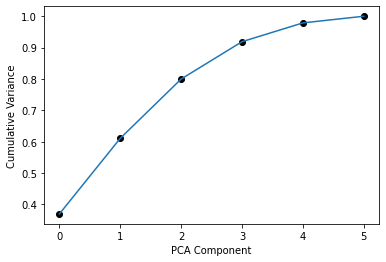

In [482]:
ratiosTeam = analyzedTeam.explained_variance_ratio_
xTeam = []
for i in range(len(ratiosTeam)):
    xTeam.append(i)
cumsumsTeam = []
countTeam = 0
for i in range(len(ratiosTeam)):
    countTeam += ratiosTeam[i]
    cumsumsTeam.append(countTeam)
totalTeam = 0
componentsTeam = 0
for i in range(len(ratiosTeam)):
    totalTeam += ratiosTeam[i]
    if totalTeam > .90:
        componentsTeam = i
        break
plt.plot(xTeam, cumsumsTeam, 'o', color='black')
plt.plot(xTeam, cumsumsTeam)
plt.xlabel("PCA Component")
plt.ylabel("Cumulative Variance")

We select **three dimensions** according to our standard and visualizations for selecting the number of dimensions.

### K-Means Algorithm


**How Many Clusters Should You Use?**

In [461]:
inertiaTeam = []
silScoresTeam = []
#tests intertia for different cluster values
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(componentPCATeam[:, :componentsTeam])
    inertiaTeam += [kmeans.inertia_]
#finds silhouette score for different cluster values
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(componentPCATeam[:, :componentsTeam])
    kSilScore = silhouette_score(componentPCATeam[:, :componentsTeam], kmeans.labels_, metric = 'euclidean')
    silScoresTeam += [kSilScore]
x = []
for i in range(1 ,10):
    x.append(i)
clusterScores = []
for i in range(2,11):
    clusterScores += [i]

#### WCSS Plot

Text(0, 0.5, 'Inertia')

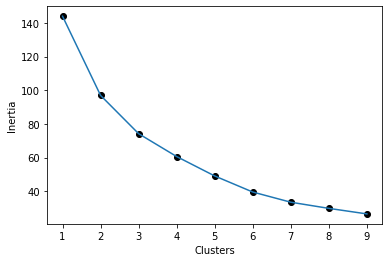

In [483]:
plt.plot(x, inertiaTeam, 'o', color='black')
plt.plot(x, inertiaTeam)
plt.xlabel("Clusters")
plt.ylabel("Inertia")

#### Silhouette Score Plot

Text(0, 0.5, 'Silhouette Score')

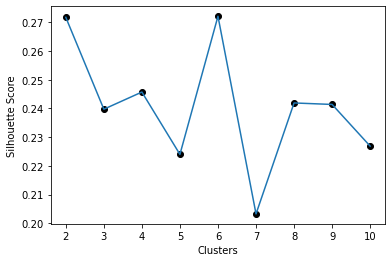

In [484]:
plt.plot(clusterScores, silScoresTeam, 'o', color='black')
plt.plot(clusterScores, silScoresTeam)
plt.xlabel("Clusters")
plt.ylabel("Silhouette Score")

From our cluster tests, we can observe that **when there are 2 clusters, the K-Means Clustering model is optimized.**

### Clustering the Optimized Data


In [466]:
finalTeam = KMeans(n_clusters = 2)
finalTeam.fit(componentPCATeam[:, :componentsTeam])

KMeans(n_clusters=2)

### Inspecting Our Clusters

**Cluster 1 seems to have all the rebuilding and non-competitive teams!**

In [467]:
finalTeams["cluster"] = finalTeam.labels_
sortedFinal = finalTeams.sort_values(by = ['W_PCT'], ascending = False)
firstTeam = sortedFinal[sortedFinal["cluster"] == 0]
display(firstTeam)

,TEAM_ID,TEAM_NAME,W_PCT,FG_PCT,FG3A,FG3_PCT,FTA,TOV,PLUS_MINUS,cluster
10,1610612745,Houston Rockets,0.646,0.449,3721,0.356,2001,1094.0,391.0,0
20,1610612760,Oklahoma City Thunder,0.598,0.454,2677,0.348,2049,1145.0,279.0,0
2,1610612751,Brooklyn Nets,0.512,0.449,2965,0.353,2088,1236.0,-6.0,0
21,1610612753,Orlando Magic,0.512,0.454,2633,0.356,1575,1082.0,58.0,0
8,1610612765,Detroit Pistons,0.500,0.440,2854,0.348,1893,1135.0,-20.0,0
15,1610612748,Miami Heat,0.476,0.450,2658,0.349,1782,1208.0,-19.0,0
3,1610612766,Charlotte Hornets,0.476,0.448,2783,0.351,1895,1001.0,-90.0,0
13,1610612747,Los Angeles Lakers,0.451,0.470,2541,0.333,1910,1284.0,-141.0,0
17,1610612750,Minnesota Timberwolves,0.439,0.456,2357,0.351,1995,1074.0,-123.0,0
18,1610612740,New Orleans Pelicans,0.402,0.473,2449,0.344,1921,1215.0,-109.0,0


**Cluster 2 seems to have all the championship contenders!**

In [487]:
secondTeam = sortedFinal[sortedFinal["cluster"] == 1]
display(secondTeam)

,TEAM_ID,TEAM_NAME,W_PCT,FG_PCT,FG3A,FG3_PCT,FTA,TOV,PLUS_MINUS,cluster
16,1610612749,Milwaukee Bucks,0.732,0.476,3134,0.353,1904,1137.0,727.0,1
27,1610612761,Toronto Raptors,0.707,0.474,2771,0.366,1803,1150.0,499.0,1
9,1610612744,Golden State Warriors,0.695,0.491,2824,0.385,1672,1169.0,530.0,1
7,1610612743,Denver Nuggets,0.659,0.466,2571,0.351,1714,1102.0,324.0,1
24,1610612757,Portland Trail Blazers,0.646,0.467,2520,0.359,1914,1135.0,344.0,1
22,1610612755,Philadelphia 76ers,0.622,0.471,2474,0.359,2258,1223.0,221.0,1
28,1610612762,Utah Jazz,0.610,0.468,2789,0.356,2092,1240.0,431.0,1
1,1610612738,Boston Celtics,0.598,0.465,2829,0.365,1598,1052.0,364.0,1
12,1610612746,LA Clippers,0.585,0.471,2118,0.388,2340,1193.0,70.0,1
11,1610612754,Indiana Pacers,0.585,0.475,2081,0.374,1727,1122.0,273.0,1


## Conclusion

You should now know how to apply K-Means clustering to NBA data after this tutorial! This tutorial should have displayed usefulness of clustering, and how machine learning methods can be leveraged in the scope of sports analytics.

Thank you for reading!

If you have any questions, please feel free to contact me at ljang@andrew.cmu.edu!

### Further Readings

Clustering is nowhere near the end of the applications of Data Science in Sports! If you're interested in learning more about Machine Learning applications in Sports, check out some of these cool articles!

**"Investigating the Importance of Pitch Selection with Clustering"**
* https://tht.fangraphs.com/investigating-the-importance-of-pitch-selection-with-clustering/

**"Clustering Pitches with PITCHf/x"**
* https://community.fangraphs.com/clustering-pitchers-with-pitchfx/

**"Using Random Forests to Forecast NBA Careers"**
* https://squared2020.com/2017/09/29/using-random-forests-to-forecast-nba-careers/

**"NBA Neural Networks: Quantifying Playoff Performance by Number of Games Won and Seeding"**
* https://medium.com/re-hoop-per-rate/nba-neural-networks-quantifying-playoff-performance-by-number-of-games-won-and-seeding-9b8e9d2f6a55
